In [1]:
# Libraries

import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

# Data Processing

In [2]:
#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time


#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

Python version: 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
pandas version: 2.2.2
matplotlib version: 3.7.2
NumPy version: 1.25.2
SciPy version: 1.11.1
IPython version: 8.15.0
scikit-learn version: 1.5.2
-------------------------


In [3]:
train_data = pd.read_csv('data/train.csv')
test_data  = pd.read_csv('data/test.csv')

# By using a list w/ references, we can clean both datasets at once
data_cleaner = [train_data, test_data]

#preview data
print (train_data.info()) 
train_data.head()
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
print('Train columns with null values:\n', train_data.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', test_data.isnull().sum())
print("-"*10)

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


In [5]:
###COMPLETING: complete or delete missing values in train and test/validation dataset
for dataset in data_cleaner:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
    #delete the cabin feature/column and others previously stated to exclude in train dataset
    drop_column = ['Cabin', 'Ticket', 'Name']
    dataset.drop(drop_column, axis=1, inplace = True)
    dataset.set_index(keys=['PassengerId'], drop=True, inplace=True)

print(train_data.isnull().sum())
print("-"*10)
print(test_data.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [6]:
###CREATE: Feature Engineering for train and test/validation dataset
for dataset in data_cleaner:    
    #Discrete variables
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

#preview data again
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,2,0
2,1,1,female,38.0,1,0,71.2833,C,2,0
3,1,3,female,26.0,0,0,7.9250,S,1,1
4,1,1,female,35.0,1,0,53.1000,S,2,0
5,0,3,male,35.0,0,0,8.0500,S,1,1


In [7]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset

#define y variable aka target/outcome
Target = ['Survived']

#define x variables for original features aka feature selection
data_x = ['Sex','Pclass', 'Embarked','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']

#code categorical data
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])

    columns_map = {'Sex': {'male': True, 'female': False}, 'Survived': {1: True, 0: False}}
    dataset.replace(columns_map, inplace=True)
    
    for i in data_x:
        if i not in ('Sex', 'Embarked'):
            dataset[i] = dataset[i].astype(float)


data_xy =  Target + data_x

#encode embarking location to categories
train_data = pd.get_dummies(train_data[data_xy])
test_data = pd.get_dummies(test_data[data_x])


In [8]:
print('Train columns with null values: \n', train_data.isnull().sum())
print("-"*10)
print (train_data.info())
print("-"*10)

print('Test/Validation columns with null values: \n', train_data.isnull().sum())
print("-"*10)
print (train_data.info())
print("-"*10)

train_data.describe(include = 'all')

Train columns with null values: 
 Survived      0
Sex           0
Pclass        0
SibSp         0
Parch         0
Age           0
Fare          0
FamilySize    0
IsAlone       0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    bool   
 1   Sex         891 non-null    bool   
 2   Pclass      891 non-null    float64
 3   SibSp       891 non-null    float64
 4   Parch       891 non-null    float64
 5   Age         891 non-null    float64
 6   Fare        891 non-null    float64
 7   FamilySize  891 non-null    float64
 8   IsAlone     891 non-null    float64
 9   Embarked_C  891 non-null    bool   
 10  Embarked_Q  891 non-null    bool   
 11  Embarked_S  891 non-null    bool   
dtypes: bool(5), float64(7)
memory usage: 60.0 KB
None
----------
Test/Valid

,Survived,Sex,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S
count,891,891,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891,891,891
unique,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2
top,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
freq,549,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,723,814,646
mean,NaN,NaN,2.308642,0.523008,0.381594,29.361582,32.204208,1.904602,0.602694,NaN,NaN,NaN
std,NaN,NaN,0.836071,1.102743,0.806057,13.019697,49.693429,1.613459,0.489615,NaN,NaN,NaN
min,NaN,NaN,1.000000,0.000000,0.000000,0.420000,0.000000,1.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,2.000000,0.000000,0.000000,22.000000,7.910400,1.000000,0.000000,NaN,NaN,NaN
50%,NaN,NaN,3.000000,0.000000,0.000000,28.000000,14.454200,1.000000,1.000000,NaN,NaN,NaN
75%,NaN,NaN,3.000000,1.000000,0.000000,35.000000,31.000000,2.000000,1.000000,NaN,NaN,NaN


In [9]:
X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train, y_train, test_size=0.33, random_state=10)
random.seed(0)
print(X_train.head())
print(y_train.head())
print(test_data.head())

               Sex  Pclass  SibSp  Parch   Age    Fare  FamilySize  IsAlone  \
PassengerId                                                                   
464           True     2.0    0.0    0.0  48.0  13.000         1.0      1.0   
160           True     3.0    8.0    2.0  28.0  69.550        11.0      0.0   
48           False     3.0    0.0    0.0  28.0   7.750         1.0      1.0   
403          False     3.0    1.0    0.0  21.0   9.825         2.0      0.0   
619          False     2.0    2.0    1.0   4.0  39.000         4.0      0.0   

             Embarked_C  Embarked_Q  Embarked_S  
PassengerId                                      
464               False       False        True  
160               False       False        True  
48                False        True       False  
403               False       False        True  
619               False       False        True  
PassengerId
464    False
160    False
48      True
403    False
619     True
Name: Survived, dty

# MOGP Algorithm

In [10]:
# Create individual minimizing 2 objectives (false positives & false negatives)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [11]:
# Setup of evolution environment (adding primitives, terminals, etc.)

random.seed(0)

# pset = gp.PrimitiveSet("MAIN", arity=1)
# pset.addPrimitive(np.add, arity=2)
# pset.addPrimitive(np.subtract, arity=2)
# pset.addPrimitive(np.multiply, arity=2)
# pset.addPrimitive(np.negative, arity=1)

# Use the following example if you want strongly-typed GP

pset = gp.PrimitiveSetTyped("main", [bool, float, float, float, float, float, float, float, bool, bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)
pset.addPrimitive(operator.xor, [bool, bool], bool)
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)

pset.addPrimitive(np.add, [float, float], float)
pset.addPrimitive(np.subtract, [float, float], float)
pset.addPrimitive(np.multiply, [float, float], float)
pset.addPrimitive(np.divide, [float, float], float)
pset.addPrimitive(np.negative, [float], float)

# pset.addPrimitive(np.add, [int, float], float)
# pset.addPrimitive(np.subtract, [int, float], float)
# pset.addPrimitive(np.multiply, [int, float], float)
# pset.addPrimitive(np.divide, [int, float], float)

# pset.addPrimitive(np.add, [int, int], int)
# pset.addPrimitive(np.subtract, [int, int], int)
# pset.addPrimitive(np.multiply, [int, int], int)
# pset.addPrimitive(np.divide, [int, int], int)
# pset.addPrimitive(np.negative, [int], int)

pset.addPrimitive(np.greater, [float, float], bool)
pset.addPrimitive(np.less, [float, float], bool)
pset.addPrimitive(np.greater_equal, [float, float], bool)
pset.addPrimitive(np.less_equal, [float, float], bool)
pset.addPrimitive(np.equal, [float, float], bool)
pset.addPrimitive(np.not_equal, [float, float], bool)

# pset.addPrimitive(np.greater, [int, int], bool)
# pset.addPrimitive(np.less, [int, int], bool)
# pset.addPrimitive(np.greater_equal, [int, int], bool)
# pset.addPrimitive(np.less_equal, [int, int], bool)
# pset.addPrimitive(np.equal, [int, int], bool)
# pset.addPrimitive(np.not_equal, [int, int], bool)

pset.addTerminal(3.0, float) # Constants
pset.addTerminal(2, float) # Constants
pset.addTerminal(5, float) # Constants
pset.addTerminal(1, bool) # Constants
# pset.addEphemeralConstant(lambda: random.randint(-10, 10), int) # Constants

# Here, use the example renameArgument function calls for every column in the titanic input data besides survived
# pset.renameArguments(ARG0='x')
# pset.renameArguments(ARG1='x')
# ...

pset.renameArguments(ARG0='Sex')
pset.renameArguments(ARG1='Pclass')
pset.renameArguments(ARG2='SibSp')
pset.renameArguments(ARG3='Parch')
pset.renameArguments(ARG4='Age')
pset.renameArguments(ARG5='Fare')
pset.renameArguments(ARG6='FamilySize')
pset.renameArguments(ARG7='IsAlone')
pset.renameArguments(ARG8='Embarked_C')
pset.renameArguments(ARG9='Embarked_Q')
pset.renameArguments(ARG10='Embarked_S')

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Evaluation Function; this will have a return value in the form of (False Positive Rate, False Negative Rate) 
def evaluatePredictor(individual, x, y, pset):
    func = gp.compile(expr=individual, pset=pset)
#     print(x)
#     print(func)
#     for i in x:
#         print("printing")
#         print(i)
    predictions = [func(*i) for i in x]
    # Here, calculate the number of false positives & false negatives in predictions    
    falsePosRate = sum([1 if (0, 1)[predictions[i] > 0] != y[i] and y[i] == 0 else 0 for i in range(len(predictions))])
    falseNegRate = sum([1 if (0, 1)[predictions[i] > 0] != y[i] and y[i] == 1 else 0 for i in range(len(predictions))])
    
    return (falsePosRate, falseNegRate)


toolbox.register("evaluate", evaluatePredictor, x=X_train.values, y=y_train.values, pset=pset) # After "points =" in this line, add the 
# processed titanic input data; Note points will have the same columns as the renameArguments calls above
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# This controls the max depth our trees can build to; python limit is 91 levels; this sets it to 17
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [12]:
# Main Evolutionary Loop
# random.seed(25)

gen = range(100)
avg_list = []
max_list = []
min_list = []
hof = tools.ParetoFront()

# Change 300 to any number of individuals we want to model
pop = toolbox.population(n=200)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for g in gen:
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring
    
    hof.update(pop)

    # Gather all the fitnesses in one list and print the stats
    fpfits = [ind.fitness.values[0] for ind in pop]
    fnfits = [ind.fitness.values[1] for ind in pop]

    length = len(pop)
    mean = sum(fpfits) / length
    sum2 = sum(x*x for x in fpfits)
    std = abs(sum2 / length - mean**2)**0.5
    g_max = max(fpfits)
    g_min = min(fpfits)
        
    avg_list.append(mean)
    max_list.append(g_max)
    min_list.append(g_min)

#     print("  Min FP %s" % g_min)
#     print("  Max FP %s" % g_max)
    print("  Avg FP %s" % mean)
#     print("  Std FP %s" % std)
    
    length = len(pop)
    mean = sum(fnfits) / length
    sum2 = sum(x*x for x in fnfits)
    std = abs(sum2 / length - mean**2)**0.5
    g_max = max(fnfits)
    g_min = min(fnfits)
        
    avg_list.append(mean)
    max_list.append(g_max)
    min_list.append(g_min)

#     print("  Min FN %s" % g_min)
#     print("  Max FN %s" % g_max)
    print("  Avg FN %s" % mean)
#     print("  Std FN %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

# I think this loop from Lab 2 should work fine with some tweaks since we can't use eaMuPlusLambda

-- Generation 0 --
  Avg FP 175.58
  Avg FN 122.59
-- Generation 1 --
  Avg FP 185.38333333333333
  Avg FN 117.82
-- Generation 2 --
  Avg FP 183.31
  Avg FN 120.15
-- Generation 3 --
  Avg FP 184.83
  Avg FN 118.92666666666666
-- Generation 4 --
  Avg FP 176.56333333333333
  Avg FN 123.07666666666667
-- Generation 5 --
  Avg FP 172.73666666666668
  Avg FN 127.01666666666667
-- Generation 6 --
  Avg FP 176.61
  Avg FN 124.32333333333334
-- Generation 7 --
  Avg FP 166.14
  Avg FN 131.82333333333332
-- Generation 8 --
  Avg FP 167.27
  Avg FN 133.20666666666668
-- Generation 9 --
  Avg FP 171.35
  Avg FN 127.95
-- Generation 10 --
  Avg FP 168.87
  Avg FN 128.30666666666667
-- Generation 11 --
  Avg FP 166.34
  Avg FN 129.98
-- Generation 12 --
  Avg FP 162.9
  Avg FN 131.28666666666666
-- Generation 13 --
  Avg FP 170.67
  Avg FN 126.15
-- Generation 14 --
  Avg FP 175.92333333333335
  Avg FN 123.98666666666666
-- Generation 15 --
  Avg FP 178.39333333333335
  Avg FN 123.94
-- Generati

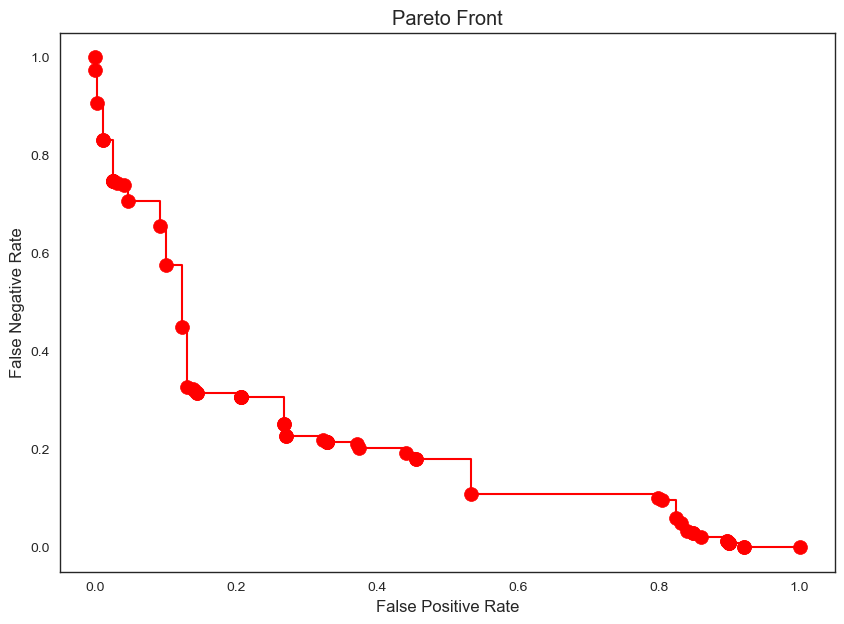

In [39]:
##
##
## Definition of Pareto dominance
"""
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal
"""



#Use this function to compare individuals: dominators = [ind for ind in pop if pareto_dominance(ind, a_given_individual)]
#a_given_individual is a set aside individual that we compare every other individual to

#initialize population & pareto
"""
pop = toolbox.population(n=MU) MU = population size -> based on our data, every function that we create
hof = tools.ParetoFront()
"""

'''
# Create a new individual for [1, 0]
individual_1 = creator.Individual()  # Initialize with default genotype
individual_1.fitness.values = (1.0, 0.0)  # Set fitness to [1, 0]

# Create a new individual for [0, 1]
individual_2 = creator.Individual()  # Initialize with default genotype
individual_2.fitness.values = (0.0, 1.0)  # Set fitness to [0, 1]

hof.update([individual_1, individual_2])
'''

'''
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("Mean Squared Error")
plt.ylabel("Tree Size")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)
'''
# Create a new individual for [1, 0]
#individual_1 = creator.Individual(None)  # Initialize with default genotype
#individual_1.fitness.values = (1.0, 0.0)  # Set fitness to [1, 0]

# Create a new individual for [0, 1]
#individual_2 = creator.Individual(None)  # Initialize with default genotype
#individual_2.fitness.values = (0.0, 1.0)  # Set fitness to [0, 1]

#hof.update([individual_1, individual_2])

totalNeg = sum([1 if i == False else 0 for i in y_train])
totalPos = sum([1 if i == True else 0 for i in y_train])

fitness_1 = [ind.fitness.values[0]/totalNeg for ind in hof]
fitness_2 = [ind.fitness.values[1]/totalPos for ind in hof]

fpr_hof = [ind.fitness.values[0]/totalNeg for ind in hof]
fnr_hof = [ind.fitness.values[1]/totalPos for ind in hof]



fitness_1.append(1.0)
fitness_2.append(0)

# fitness_2.append(1.0)
# fitness_1.append(0)

fpr_hof.append(1.0)
fnr_hof.append(0)

fnr_hof.append(1.0)
fpr_hof.append(0)

plt.figure(figsize=(10, 7))
plt.scatter(fpr_hof, fnr_hof, color='r', label='Pareto Front', s=100)
sorted_indices = np.argsort(fpr_hof)
fpr_hof_sorted = np.array(fpr_hof)[sorted_indices]
fnr_hof_sorted = np.array(fnr_hof)[sorted_indices]
#plt.plot(fpr_hof_sorted, fnr_hof_sorted, color='r', linestyle='--')


plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

In [24]:
print(totalNeg)
print(totalPos)

358
238
